In [1]:
import random
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
def check_weights(df,w,theta):
    '''checks the weights returned by winnow model with any dataframe, assuming last column is label category'''
    df_dum = build_dummies(df)
    sums = [sum(a*b for a,b in zip(df_dum.iloc[i,:],w)) for i in range(len(df_dum))]
    classified = [i >= theta for i in sums]
    
    return all(a == b for a,b in zip(classified, df.iloc[:,-1]))

In [3]:
def predict_winnow_sample(sample,pred,weights,threshold):
    classified = np.dot(sample,weights)
    if classified >= threshold:
        #return 1 == pred
        return True
    else:
        #return 0 == pred
        return False

In [4]:
def predict_winnow(df,preds,weights,threshold):
    correct = []
    for i in range(len(df)):
        correct.append(predict_winnow_sample(df.iloc[i,:],preds[i],weights,threshold))
    return correct

In [5]:
def test_train_split(df,fraction, discretize = False, n_bins = 10):
    
    num = math.ceil(len(df)*fraction)
        
    if discretize:
        y_data = df.iloc[:,len(df.columns)-1]
        X_data = df.iloc[:,:-1] #remove class column
        
        scaler = StandardScaler(copy=True)
        Xt = scaler.fit_transform(X_data)
        est = KBinsDiscretizer(n_bins, encode ='onehot-dense',strategy='quantile')
        Xt1 = est.fit_transform(Xt)
        Xt2 = pd.DataFrame(Xt1)
        
        Xt2.insert(len(Xt2.columns),'Class',y_data)
        train = Xt2.sample(n = num, replace = False)
        test = Xt2[~Xt2.index.isin(train.index)]
        train = train.reset_index(drop=True,inplace=False)
        test = test.reset_index(drop=True,inplace = False)
        
        X_train = train.iloc[:,0:-1]
        y_train = train.iloc[:,-1]
        X_test = test.iloc[:,0:-1]
        y_test = test.iloc[:,-1]

        return X_train,y_train,X_test,y_test
    
    else:
        
        train = df.sample(n = num, replace = False)
        test = df[~df.index.isin(train.index)]
        train = train.reset_index(drop=True,inplace=False)
        test = test.reset_index(drop=True,inplace = False)
        
        X_train = train.iloc[:,0:-1]
        y_train = train.iloc[:,-1]
        X_test = test.iloc[:,0:-1]
        y_test = test.iloc[:,-1]
   
    return X_train,y_train,X_test,y_test

In [6]:
def build_dummies(df):
    if df.columns[0] == 'id':
        df = df.iloc[:,1:]
    else:
        df = df.iloc[:,0:]
    df_dum = pd.DataFrame()
    for i in range(len(df.columns)):
        temp = pd.get_dummies(df.iloc[:,i],drop_first=False,prefix = df.columns[i])
        df_dum = pd.concat([df_dum,temp], axis = 1)
    
    return df_dum

In [7]:
def discretize_values(df,num_bins):
    #label = df.iloc[:,-1]
    add_id = False
    df2 = df.copy()
    if df2.columns[0] == 'id':
        id = df2.iloc[:,0]
        add_id = True
        df2 = df2.iloc[:,1:] #drop off id and label fields
    for cols in df2:
            bins = pd.cut(df2[cols],num_bins, labels = range(num_bins),duplicates = 'drop')#[x for x in range(num_bins)])
            df2[cols] = bins
    if add_id:
        df2.insert(0,'id',id)
    #df.insert(len(df.columns),'label',label)
    #print(df)
    return build_dummies(df2)


In [8]:
#assume first column is index and last column is label

def winnow(df, labels, theta=5, alpha=2):
    
    '''This function access df,...
    assumes that df fields are ...'''
    
    width_df = len(df.columns)
    weights = [1]*(width_df)
    done = False
    errors = 0
 
    while not done:
        done = True
        for i in range(len(df)):
            classified = (sum([a*b for a,b in zip(weights,df.iloc[i,:])]) > theta)
            #print(sum([a*b for a,b in zip(weights,df.iloc[i,:])]))
            if classified != labels[i]:
                errors += 1
                done = False
                if classified == True and labels[i] == 0: #demote
                    weights = [weights[k]/alpha if df.iloc[i,k] == 1 else weights[k] for k in range(width_df)]
                else: #promote
                    weights = [weights[k]*alpha if df.iloc[i,k] == 1 else weights[k] for k in range(width_df)]
    return weights,errors

In [9]:
def train_models(df, preds, num_classes,theta,alpha):
    weights = []

    for i in range(num_classes):
        to_replace = {i:0 for i in range(num_classes)}
        to_replace[i] = 1
        temp = preds.replace(to_replace,inplace=False)
        w, e = winnow(df,temp,theta,alpha)
        weights.append(w)
        
    return weights

In [10]:
def multi_class_pred(df, weights,theta):

    closest = 100000
    temp = 0
    num_rows = len(df)
    num_classes = len(weights)
    winner = -1
    
    for i in range(num_classes):                     
        #wxv = abs(sum(np.dot(df,weights[i])) - theta) 
        wxv = abs(np.dot(df,weights[i]) - theta)
        if wxv < closest:
            closest = wxv
            winner = i
                
    return winner if winner >= 0 else None

In [11]:
def multi_class_pred_df(df,weights,theta):
    preds = []
    
    for i in range(len(df)):
        preds.append(multi_class_pred(df.iloc[i,:], weights,theta))
    return preds

In [12]:
def confusion(y_act,y_pred, margins = False):
    #y_act = pd.Categorical(y_test.astype(bool))
    y_pred = pd.Categorical(y_pred)
    df_conf = pd.crosstab(y_act, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=margins)

    return df_conf

In [13]:
def confusion_statistics(conf_table):
    total = conf_table[0][0] + conf_table[0][1] + conf_table[1][0] + conf_table[1][1] 
    print("Pred False, Actual False (%): {:.2f}".format(a[0][0]/total))
    print("Pred True, Actual True (%): {:.2f}".format(a[1][1] / total))
    print("Pred False, Actual True (%): {:.2f}".format(a[0][1]/total))
    print("Pred True, Actual False (%): {:.2f}".format(a[1][0]/total))

In [14]:
def plot_confusion_matrix(df_conf, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_conf, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_conf.columns))
    plt.xticks(tick_marks, df_conf.columns, rotation=45)
    plt.yticks(tick_marks, df_conf.index)
    #plt.tight_layout()
    plt.ylabel(df_conf.index.name)
    plt.xlabel(df_conf.columns.name)

In [15]:
#Breast Cancer Dataset

bc = pd.read_csv('breast-cancer-wisconsin.data', names = ['id','Clump Thickness','Uniformity of Size', 'Uniformity of Shape',
                                                         'Adhesion','Size','Bare Nuclei','Bland Chromatin','Norm Nucleoli',
                                                          'Mitoses', 'Class'])
bc = bc.drop(bc[bc['Bare Nuclei']== '?'].index)
bc['Bare Nuclei'] =  bc['Bare Nuclei'].astype(int)
bc = bc.reset_index(drop=True)
rep = {2:0,4:1}
bc['Class'] = bc['Class'].replace(rep,inplace = False)

temp = bc.iloc[:,0:-1]
temp = build_dummies(temp)
temp.insert(loc = len(temp.columns), column='Class', value = list(bc.iloc[:,-1]))

In [16]:
X_train,y_train,X_test,y_test = test_train_split(temp,.67)
w,err = winnow(X_train,y_train,45,1.2)

In [17]:
w

[0.6944444444444445,
 5.159780351999999,
 2.48832,
 0.8333333333333334,
 4.299816959999999,
 0.48225308641975323,
 10.699320537907196,
 8.916100448255998,
 5.159780351999999,
 18.48842588950363,
 0.13458798574153816,
 5.159780351999999,
 7.430083706879999,
 0.3348979766803842,
 12.839184645488634,
 8.916100448255998,
 1.0,
 8.916100448255998,
 3.5831807999999996,
 22.186111067404358,
 0.1615055828898458,
 1.2,
 4.299816959999999,
 4.299816959999999,
 8.916100448255998,
 7.430083706879999,
 5.159780351999999,
 6.191736422399999,
 2.9859839999999997,
 6.191736422399999,
 1.2,
 1.2,
 6.191736422399999,
 8.916100448255998,
 3.5831807999999996,
 2.9859839999999997,
 4.299816959999999,
 3.5831807999999996,
 1,
 10.699320537907196,
 0.8333333333333334,
 4.299816959999999,
 5.159780351999999,
 4.299816959999999,
 10.699320537907196,
 2.9859839999999997,
 4.299816959999999,
 1.44,
 1,
 8.916100448255998,
 1.2,
 1.44,
 7.430083706879999,
 3.5831807999999996,
 2.48832,
 4.299816959999999,
 2.9859

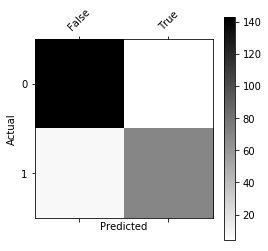

In [18]:
t = predict_winnow(X_test,y_test,w,45)
a = confusion(y_test,t)
plot_confusion_matrix(a)

In [19]:
confusion_statistics(a)

Pred False, Actual False (%): 0.64
Pred True, Actual True (%): 0.31
Pred False, Actual True (%): 0.04
Pred True, Actual False (%): 0.02


In [20]:
a

Predicted,False,True
Actual,,
0,143,4
1,8,70


In [21]:
#Glass dataset
glass_df = pd.read_csv('glass.data',names = ['id', 'RI','Na','Mg','Al',
                                             'Si','K','Ca','Ba','Fe',
                                             'Class'])
glass_df = glass_df.iloc[:,1:]

#contain values {1, 2, 3, 5, 6, 7} in class field

glass_df['Class'] = glass_df['Class'].astype("category").cat.codes
X_train,y_train,X_test,y_test = test_train_split(glass_df,.67,True,10)

In [22]:
#Model would not train on custom discretize function 
#X_train,y_train,X_test,y_test = test_train_split(glass_df,.75)
#Xt = discretize_values(X_train,10)

In [23]:
#Xdisc_glass_train = discretize_values(X_train,10) 
#Xdisc_glass_test = discretize_values(X_test,10) 

#Build up datasets to run winnow one at a time on
to_replace0 = {0:1,1:0,2:0,3:0,4:0,5:0}
train_glass_zero = y_train.replace(to_replace0,inplace=False)
test_glass_zero = y_test.replace(to_replace0,inplace=False)

to_replace1 = {0:0,1:1,2:0,3:0,4:0,5:0}
train_glass_one = y_train.replace(to_replace1,inplace=False)
test_glass_one = y_test.replace(to_replace1,inplace=False)

to_replace2 = {0:0,1:0,2:1,3:0,4:0,5:0}
train_glass_two = y_train.replace(to_replace2,inplace=False)
test_glass_two = y_test.replace(to_replace2,inplace=False)

to_replace3 = {0:0,1:0,2:0,3:1,4:0,5:0}
train_glass_three = y_train.replace(to_replace3,inplace=False)
test_glass_three = y_test.replace(to_replace3,inplace=False)

to_replace4 = {0:0,1:0,2:0,3:0,4:1,5:0}
train_glass_four = y_train.replace(to_replace4,inplace=False)
test_glass_four = y_test.replace(to_replace4,inplace=False)

to_replace5 = {0:0,1:0,2:0,3:0,4:0,5:1}
train_glass_five = y_train.replace(to_replace5,inplace=False)
test_glass_five = y_test.replace(to_replace5,inplace=False)


In [24]:
#Train glass df
w0,e0 = winnow(X_train,train_glass_zero,35,1.2)
#w1,e1 = winnow(X_train,train_glass_one,35,1.2)
#w2,e2 = winnow(X_train,train_glass_two,35,1.2)
#w3,e3 = winnow(X_train,train_glass_three,35,1.2)
#w4,e4 = winnow(X_train,train_glass_four,35,1.2)
#w5,e5 = winnow(X_train,train_glass_five,35,1.2)

In [25]:
wts = train_models(X_train,y_train,6,35,1.2)

In [26]:
wts[0] == w0

True

In [27]:
a = multi_class_pred_df(X_test,wts,35)
confusion(y_test,a)

Predicted,0,1,2,3,4,5
Actual,,,,,,
0,9,5,7,1,0,0
1,13,6,4,2,0,2
2,0,5,3,0,0,0
3,0,3,0,1,0,0
4,0,0,0,0,2,1
5,0,2,0,2,1,1


In [ ]:
len(y_test)

Tried strategy quantile, uniform (winner quantile)
Tried bin size 3 to 10
Tried theta 1.1 to 4
Theta of 1.2 was sweetspot
Feature scaling reduced time by 75%

In [28]:
#Iris Dataset
iris_df = pd.read_csv('iris.data', names = ['slength','swidth','plength','pwidth','Class'])

#change cateogires as follows:
#Iris-setosa: 0
#Iris-versicolor: 1
#Iris-virginica: 2
iris_df['Class'] = iris_df['Class'].astype("category").cat.codes

#temp = iris_df.iloc[:,0:-1]
#discretized = discretize_values(temp,10) 
#discretized.insert(loc = len(discretized.columns), column='Class', value = list(iris_df.iloc[:,-1]))
#X_train,y_train,X_test,y_test = test_train_split(df = discretized,fraction = .67)



In [29]:
len(iris_df)

150

In [30]:
X_train,y_train,X_test,y_test = test_train_split(iris_df,.67,True,10)
#Build up datasets to run winnow one at a time on
to_replace0 = {0:1,1:0,2:0}
train_iris_zero = y_train.replace(to_replace0,inplace=False)
test_iris_zero = y_test.replace(to_replace0,inplace=False)

to_replace1 = {0:0,1:1,2:0}
train_iris_one = y_train.replace(to_replace1,inplace=False)
test_iris_one = y_test.replace(to_replace1,inplace=False)

to_replace2 = {0:0,1:0,2:1}
train_iris_two = y_train.replace(to_replace2,inplace=False)
test_iris_two = y_test.replace(to_replace2,inplace=False)

In [31]:
len(X_train.columns)

38

In [32]:
w0,e0 = winnow(X_train,train_iris_zero,20,1.2)
w1,e1 = winnow(X_train,train_iris_one,20,1.2)
w2,e2 = winnow(X_train,train_iris_two,20,1.2)

In [33]:
wts = train_models(X_train,y_train,3,20,1.2)
a = multi_class_pred_df(X_test,wts,20)


In [34]:
confusion(y_test,a)

Predicted,0,1,2
Actual,,,
0,9,1,2
1,1,7,7
2,2,5,15


In [ ]:
34/49

In [40]:
#Soybean Dataset
#there are 9 rows of all zeros, I remove those because winnow doesn't care if these exist or not
soy_df = pd.read_csv('soybean-small.data',names = ['A{}'.format(i) for i in range(35)] + ['Class'])
soy_df = soy_df.loc[:, (soy_df != 0).any(axis=0)]
soy_df['Class'] = soy_df['Class'].astype("category").cat.codes


In [41]:
#Build up datasets to run winnow one at a time on
temp = soy_df.iloc[:,0:-1]
temp = build_dummies(temp)
temp.insert(loc = len(temp.columns), column='Class', value = list(soy_df.iloc[:,-1]))
X_train,y_train,X_test,y_test = test_train_split(temp,.67)

to_replace0 = {0:1,1:0,2:0,3:0}
train_soy_zero = y_train.replace(to_replace0,inplace=False)
test_soy_zero = y_test.replace(to_replace0,inplace=False)

to_replace1 = {0:0,1:1,2:0,3:0}
train_soy_one = y_train.replace(to_replace1,inplace=False)
test_soy_one = y_test.replace(to_replace1,inplace=False)

to_replace2 = {0:0,1:0,2:1,3:0}
train_soy_two = y_train.replace(to_replace2,inplace=False)
test_soy_two = y_test.replace(to_replace2,inplace=False)

to_replace3 = {0:0,1:0,2:0,3:1}
train_soy_three = y_train.replace(to_replace3,inplace=False)
test_soy_three = y_test.replace(to_replace3,inplace=False)





In [37]:
w0,err0 = winnow(X_train,train_soy_zero,31,2)
w1,err1 = winnow(X_train,train_soy_one,31,2)
w2,err2 = winnow(X_train,train_soy_two,31,2)
w3,err3 = winnow(X_train,train_soy_three,31,2)

In [42]:
wts = train_models(X_train,y_train,4,31,2)
a = multi_class_pred_df(X_test,wts,31)

In [43]:
confusion(y_test,a)

Predicted,0,1,2
Actual,,,
0,0,5,0
1,0,3,0
2,1,0,2
3,2,2,0


In [ ]:
5/11

In [44]:
names = ['Class',
   'infants',
   'water',
   'budget',
   'physician',
   'elsal',
   'religious',
   'anti-sat',
   'contras',
   'missile',
   'immigration',
   'synfuels',
   'education',
   'sue',
   'crime',
   'exports',
   'eaa']

In [45]:
votes = pd.read_csv('house-votes-84.data',names = names)
votes = votes[[c for c in votes if c not in ['Class']] + ['Class']]
votes['Class'] = votes['Class'].astype("category").cat.codes
votes2 = votes[(votes != '?').all(axis=1)]
#this removes over 200 of my sample points

In [ ]:
len(votes)

In [46]:
#handle imputations
vote_dic = defaultdict(lambda: defaultdict(int))

for index,row in votes.iterrows():
    for cols in votes.columns:
        if cols != 'Class':
            if row[cols] == 'y':
                vote_dic[row['Class']][cols] +=1

In [47]:
#data imputation - using most likely vote based on party
for i in votes.index:
    for cols in votes.columns:
        if votes[cols][i] == '?' and votes['Class'][i] == 1:
            votes.at[i,cols] = 'y' if vote_dic[1][cols] > vote_dic[0][cols] else 'n'
        elif votes[cols][i] == '?' and votes['Class'][i] == 0: 
            votes.at[i,cols] = 'y' if vote_dic[0][cols] > vote_dic[1][cols] else 'n'

In [48]:
for cols in votes:
    votes[cols] = votes[cols].astype("category").cat.codes

In [49]:
votes.dtypes

infants        int8
water          int8
budget         int8
physician      int8
elsal          int8
religious      int8
anti-sat       int8
contras        int8
missile        int8
immigration    int8
synfuels       int8
education      int8
sue            int8
crime          int8
exports        int8
eaa            int8
Class          int8
dtype: object

In [52]:
temp = votes.iloc[:,0:-1]
temp = build_dummies(temp)
temp.insert(loc = len(temp.columns), column='Class', value = list(votes.iloc[:,-1]))
X_train,y_train,X_test,y_test = test_train_split(temp,.27)

In [53]:
a = winnow(X_train,y_train,16,1.2)

KeyboardInterrupt: 

In [ ]:
preds = predict_winnow(preds,y_test,w,8)

In [ ]:
confusion(preds,y_test)

In [54]:
def class_prob(classdata):
    class_totals = defaultdict(int)
    class_prob = defaultdict(int)
    #listdf = df.values.tolist()
    total = len(classdata)
    for i in classdata:
        class_totals[i] += 1
    for key in class_totals:
        class_prob[key] = class_totals[key]/total
    return class_totals, class_prob

In [55]:
def splitByClass(X,y):
    classData = defaultdict(list)    
    listdf = X.values.tolist()
    for i in range(len(listdf)):
        row = listdf[i]
        classData[y[i]].append(row)
    return classData

In [56]:
def feature_stats(X):
    '''results verified with excel'''
    feature_data = defaultdict(list)
    features = X.values.tolist()
    stats = [(np.mean(feature), np.var(feature)) for feature in zip(*features)]
    for i in range(len(X.columns)):
        feature_data[X.columns[i]] = stats[i]
    
    return feature_data

In [57]:
def feature_stats_byClass(classdict):
    '''results verified with excel'''
    features_byClass = defaultdict(dict)
    for key in classdict:
        classmean = [np.mean(feature) for feature in zip(*classdict[key])]
        classvar = [np.var(feature,dtype=np.float64) for feature in zip(*classdict[key])]
        features_byClass[key] = {"mean":classmean,"var":classvar}
    
    return features_byClass

In [58]:
from scipy.stats import norm
def prob_calc(xval,xmean,xvariance):
    '''assume iid, normally distributed sampling distribution'''
    return norm.pdf(xval,xmean,xvariance) + 1/100
    

In [59]:
def predict(test, fstats,by_class,classprob):
    '''given data, looking for P(class | data) using the trained data from from feature values'''
    #which class has highest probability given the data?
    classes = classprob.keys()
    post = {x:-1 for x in range(len(test))}
    preds = [-1]*len(test)
    for i in range(len(test)):
        for j in classes:
            prob_class = classprob[j]
            maxprob = 0
            likelihood = 1
            for k in range(len(test.columns)):
                likelihood = likelihood * (prob_calc(test.iloc[i,k]+.1,by_class[j]['mean'][k]+.1,by_class[j]['var'][k]+.1))

            posterior = likelihood * prob_class

            if posterior > post[i]:                
                post[i] = posterior
                preds[i] = j
                
    return preds
            
                
    

In [ ]:
classprob

In [60]:
#train on bc
X_train,y_train,X_test,y_test = test_train_split(bc.iloc[:,1:],.67)
fstats = feature_stats(X_train)
by_class = feature_stats_byClass(splitByClass(X_train,y_train))
classtot,classprob = class_prob(y_train)
bc_nb = predict(X_test,fstats,by_class,classprob)
bc_nb_test_y = y_test
confusion(bc_nb_test_y,bc_nb)

Predicted,0,1
Actual,,
0,136,3
1,18,68


In [61]:
#train on glass_df
X_train,y_train,X_test,y_test = test_train_split(glass_df,.67)
fstats = feature_stats(X_train)
by_class = feature_stats_byClass(splitByClass(X_train,y_train))
classtot,classprob = class_prob(y_train)
glass_nb = predict(X_test,fstats,by_class,classprob)
glass_nb_test_y = y_test
confusion(glass_nb_test_y,glass_nb)

Predicted,0,1,2,3,4,5
Actual,,,,,,
0,15,0,5,0,2,0
1,21,3,0,0,2,0
2,5,0,1,0,1,0
3,0,2,0,1,0,1
4,0,0,0,0,2,0
5,0,0,0,0,0,9


In [62]:
#train on iris_df
X_train,y_train,X_test,y_test = test_train_split(iris_df,.67)
fstats = feature_stats(X_train)
by_class = feature_stats_byClass(splitByClass(X_train,y_train))
classtot,classprob = class_prob(y_train)
glass_nb = predict(X_test,fstats,by_class,classprob)
glass_nb_test_y = y_test
confusion(glass_nb_test_y,glass_nb)

Predicted,0,1,2
Actual,,,
0,19,0,0
1,0,15,0
2,0,2,13


In [63]:
#train on soy
X_train,y_train,X_test,y_test = test_train_split(soy_df,.67)
fstats = feature_stats(X_train)
by_class = feature_stats_byClass(splitByClass(X_train,y_train))
classtot,classprob = class_prob(y_train)
glass_nb = predict(X_test,fstats,by_class,classprob)
glass_nb_test_y = y_test
confusion(glass_nb_test_y,glass_nb)

Predicted,0,1,2,3
Actual,,,,
0,4,0,0,0
1,0,3,0,0
2,0,0,1,0
3,0,0,0,7


In [64]:
#train on votes
X_train,y_train,X_test,y_test = test_train_split(votes,.67)
fstats = feature_stats(X_train)
by_class = feature_stats_byClass(splitByClass(X_train,y_train))
classtot,classprob = class_prob(y_train)
glass_nb = predict(X_test,fstats,by_class,classprob)
glass_nb_test_y = y_test
confusion(glass_nb_test_y,glass_nb)

Predicted,0,1
Actual,,
0,68,11
1,2,62
